In [27]:
import pandas as pd
import numpy as np
import datetime as dt
import pylab as pl
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline
import seaborn as sns
import itertools
import scipy.stats as scs
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm
from IPython.display import HTML, display
from collections import Counter

In [28]:
df = pd.read_csv("shareViewDataRM-ext.csv")

In [29]:
df.columns = df.columns.str.lstrip()

In [30]:
df.columns = df.columns.str.lower()

In [31]:
df.columns = df.columns.str.replace(" ", "_")

# EDA & Feature Engineering

In [32]:
df.user_os.unique()


array([nan, 'WINDOWS_7', 'WINDOWS_10', 'MAC_OS_X', 'MAC_OS_X_IPHONE',
       'WINDOWS_XP', 'WINDOWS_81', 'ANDROID6', 'ANDROID_MOBILE',
       'CHROME_OS', 'MAC_OS_X_IPAD', 'ANDROID4_TABLET', 'WINDOWS_8',
       'iOS8_1_IPAD'], dtype=object)

In [33]:
df.rename(columns={'user_os': 'viewing_device'}, inplace=True)
df["viewing_device"].replace({"MAC_OS_X" : "Laptop/Desktop", "WINDOWS_XP" : "Laptop/Desktop", "WINDOWS_8" : "Laptop/Desktop", "WINDOWS_10" : "Laptop/Desktop", "WINDOWS_7" : "Laptop/Desktop", "WINDOWS_81" : "Laptop/Desktop", "CHROME_OS" : "Laptop/Desktop"}, inplace = True)
df["viewing_device"].replace({"ANDROID_MOBILE" : "Phone", "ANDROID6" : "Phone", "ANDROID4" : "Phone", "ANDROID5" : "Phone","ANDROID7" : "Phone", "MAC_OS_X_IPHONE" : "Phone", "iOS7_IPHONE" : "Phone", "iOS8_1_IPHONE" : "Phone", "iOS8_3_IPHONE" : "Phone", "iOS9_IPHONE" : "Phone"}, inplace=True)
df["viewing_device"].replace({"ANDROID4_TABLET" : "Tablet", "ANDROID6_TABLET" : "Tablet", "iOS8_1_IPAD" : "Tablet", "MAC_OS_X_IPAD" : "Tablet"}, inplace = True)


In [34]:
df.viewing_app.unique()

array([nan, 'CHROME', 'IE11', 'SAFARI', 'EDGE', 'FIREFOX', 'EDGE14',
       'EDGE13', 'EDGE12', 'MOBILE_SAFARI', 'CHROME49', 'FIREFOX34',
       'CHROME45', 'CHROME_MOBILE', 'SAFARI9', 'SAFARI5', 'FIREFOX48',
       'CHROME48', 'FIREFOX46', 'CHROME41', 'CHROME28'], dtype=object)

In [35]:
df.rename(columns={'viewing_app': 'browser'}, inplace=True)
df["browser"].replace({"CHROME45" : "CHROME", "CHROME49" : "CHROME", "CHROME41" : "CHROME", "CHROME48" : "CHROME", "CHROME28" : "CHROME", "FIREFOX34" : "FIREFOX", "FIREFOX46" : "FIREFOX", "FIREFOX48" : "FIREFOX", "EDGE12" : "EDGE"}, inplace = True)
df["browser"].replace({"EDGE13" : "EDGE", "EDGE14" : "EDGE", "SAFARI5" : "SAFARI", "SAFARI9" : "SAFARI"}, inplace=True)
df.browser.unique()

array([nan, 'CHROME', 'IE11', 'SAFARI', 'EDGE', 'FIREFOX', 'MOBILE_SAFARI',
       'CHROME_MOBILE'], dtype=object)

In [36]:
df["shared_date"] = pd.to_datetime(df["shared_date"], format="%d-%b-%Y")

In [37]:
df["last_activity_date"] = pd.to_datetime(df["last_activity_date"], format="%d-%b-%Y")

In [38]:
df['weekday'] = df['last_activity_date'].dt.dayofweek
df["weekday_name"] = df['last_activity_date'].dt.weekday_name
df["month"] = df['last_activity_date'].dt.month
df["time_of_day"] = pd.to_datetime(df['last_activity_time'], format='%H:%M:%S').dt.hour
df.time_of_day.unique()

array([22, 21, 20,  3, 15, 23,  1, 11,  4,  0,  6, 19,  9,  5, 12, 14, 13,
       10,  8,  7,  2, 18, 16, 17])

In [39]:
# 1: Night(Midnight to 6 am), 2: Morning(6 am to Noon), 3: Afternoon(Noon to 6 pm), 4: Evening(6 pm to Midnight)
df["time_of_day"].replace({0 : 1, 2 : 1, 3 : 1, 4 : 1, 5 : 1}, inplace = True)
df["time_of_day"].replace({6 : 2, 7 : 2, 8 : 2, 9 : 2, 10 : 2, 11 : 2}, inplace = True)
df["time_of_day"].replace({12 : 3, 13 : 3, 14 : 3, 15 : 3, 16 : 3, 17 : 3}, inplace = True)
df["time_of_day"].replace({18 : 4, 19 : 4, 20 : 4, 21 : 4, 22 : 4, 23 : 4,}, inplace = True)
df.time_of_day.unique()

array([4, 1, 3, 2])

In [40]:
df['hour'] = pd.to_datetime(df['last_activity_time'], format='%H:%M:%S').dt.hour

In [41]:
df.viewed.unique()

array([1, 0])

In [42]:
df["time_spent_mins"] = df["time_spent_in_seconds"]/60.

In [43]:
hour_grouped = df.groupby("time_of_day")["time_spent_mins"].sum()

In [44]:
# plot = plt.bar(xrange(0,4),(df.groupby("time_of_day")["time_spent_mins"].sum()))
# plt.xticks(xrange(0,4),["Night", "Morning", "Afternoon", "Evening"])


In [45]:
#sns.distplot(df["time_spent_mins"], color="m")
len(df)

2463

In [46]:
#new_df = df[df["time_spent_mins"] <= 10]
#plot = plt.hist(new_df["time_spent_mins"])
#plt.boxplot(new_df["time_spent_mins"])

#len(new_df) 
#1917 (22% reduced)
#sns.distplot(new_df["time_spent_mins"], color="g")

# SHARE DATA ANALYSIS

In [47]:
share_df = df[df.activity_type == "SHARE"]
share_df.columns

Index([u'activity_type', u'user_id', u'rm_id', u'viewing_device', u'browser',
       u'view_app_group', u'user_groups', u'shared_date', u'shared_hour',
       u'shared_time', u'title_of_content', u'doc_type', u'share_channel',
       u'viewed', u'time_spent_in_seconds', u'last_activity_date',
       u'last_activity_time', u'weekday', u'weekday_name', u'month',
       u'time_of_day', u'hour', u'time_spent_mins'],
      dtype='object')

In [48]:
y_time_spent = share_df.groupby("weekday")["time_spent_mins"].sum

In [49]:
#sns.stripplot(x=share_df["weekday_name"], y=share_df["time_spent_mins"], data=share_df, jitter=True)

In [50]:
len(share_df), len(share_df.user_id.unique())

(378, 263)

In [56]:
share_df['num_of_day_from_share_view'] = (share_df["last_activity_date"] - share_df["shared_date"]).astype(dt.timedelta).map(lambda x: 0 if pd.isnull(x) else x.days)
share_df["num_of_day_from_share_view"].unique()

# sns.distplot(share_df["num_of_day_from_share_view"], color="m")

/Users/urmimukherjee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


array([  0,   8, 475,  28,   6,  16,  99,  12,   4,   1, 395,   7, 293,
         2,  15,  76,  75,  14,  65,  34,  59,  90,  49,  87,  83,  43,
        80,  82, 364,  97, 371,   5, 173,  74,  73,   9,  77,  70,  66,
        91, 103, 191,  67,  51, 135, 100, 284,  10, 223,  69,  20,  68,
        64,  63, 154, 112, 105,  45,  48,  78,  47,   3])

(array([  1.68755221e-02,   3.17460317e-03,   4.45558340e-04,
          1.11389585e-04,   1.11389585e-04,   5.56947925e-05,
          5.56947925e-05,   1.11389585e-04,   5.56947925e-05,
          5.56947925e-05]),
 array([   0. ,   47.5,   95. ,  142.5,  190. ,  237.5,  285. ,  332.5,
         380. ,  427.5,  475. ]),
 <a list of 10 Patch objects>)

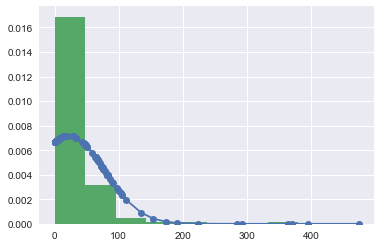

In [57]:
import pylab as pl
h = sorted(share_df["num_of_day_from_share_view"])  #sorted

fit = norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed

pl.plot(h,fit,'-o')

pl.hist(h,normed=True)

<module 'pylab' from '/Users/urmimukherjee/anaconda2/lib/python2.7/site-packages/pylab.pyc'>

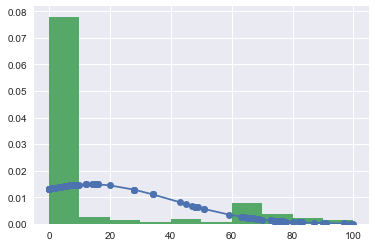

In [58]:
import pylab as pl
days_share_view = share_df[share_df["num_of_day_from_share_view"]<=100]
len(share_df),len(days_share_view)
h = sorted(days_share_view["num_of_day_from_share_view"]) #sorted

fit = norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed

pl.plot(h,fit,'-o')

pl.hist(h,normed=True)
pl

In [59]:
# uniq_titles = np.sort(share_df.title_of_content.unique())
# uniq_title_num_share = share_df.groupby("title_of_content")["activity_type"].count()
# #uniq_titles 
# uniq_title_num_share

In [60]:
# import pylab as pl
# h = sorted(share_df["time_spent_mins"])  #sorted

# fit = norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed

# pl.plot(h,fit,'-o')

# pl.hist(h,normed=True)


In [61]:
#share_df["weekday"].plot.kde()

In [62]:
# plot = plt.bar(xrange(0,7),(share_df.groupby("weekday")["time_spent_mins"].sum()))
# plt.xticks(xrange(0,7),["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"])
# share_weekday = share_df.groupby("weekday")["time_spent_mins"].sum()

In [63]:
# plot = plt.bar(xrange(0,7),(share_df.groupby("month")["time_spent_mins"].sum()))
# plt.xticks(xrange(0,7),["Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug"])

In [64]:
# import pylab as pl
# new_share = share_df[share_df["time_spent_mins"]<=8]
# h = sorted(new_share["time_spent_mins"])  #sorted

# fit = norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed

# pl.plot(h,fit,'-o')
# pl.axvline(x=np.mean(h)+np.std(h),color='r', linestyle='--')
# pl.axvline(x=np.mean(h)-np.std(h),color='r', linestyle='--')
# pl.hist(h,normed=True)


In [65]:
#h = plt.hist(share_df.time_spent_mins)

In [66]:
#sns.stripplot(x="share_channel", y="time_spent_mins", data=share_df)


([<matplotlib.axis.XTick at 0x121249e50>,
 <a list of 2 Text xticklabel objects>)

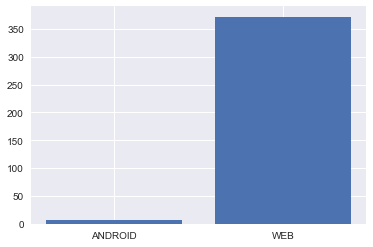

In [67]:
plt.bar(xrange(0,2),(share_df.groupby("share_channel")["time_spent_mins"].count()))
plt.xticks(xrange(0,2),["ANDROID", "WEB"])
# plt.xlabel("Share Channel")
# plt.ylabel("Number of Shares")
# plt.title("TW - Num Shares Vs Share Channel")

In [68]:
#sns.stripplot(x="time_of_day", y="time_spent_mins", data=share_df)


# VIEW DATA ANALYSIS

In [69]:
view_df = df[(df.activity_type == "VIEW")]
view_df = view_df.drop(["share_channel", "user_groups", "shared_date", "shared_time", "rm_id", "shared_hour"], axis =1)
view_df.describe()

,user_id,viewed,time_spent_in_seconds,weekday,month,time_of_day,hour,time_spent_mins
count,2.085000e+03,2085.0,2085.000000,2085.000000,2085.000000,2085.000000,2085.000000,2085.000000
mean,3.515273e+06,1.0,366.052278,2.660911,3.866187,2.211031,9.888729,6.100871
std,1.976219e+06,0.0,771.334288,1.806533,1.453315,1.243244,7.987159,12.855571
min,1.975210e+05,1.0,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000
25%,8.201110e+05,1.0,10.000000,1.000000,3.000000,1.000000,3.000000,0.166667
50%,4.369882e+06,1.0,35.000000,3.000000,3.000000,2.000000,8.000000,0.583333
75%,4.931992e+06,1.0,310.000000,4.000000,5.000000,4.000000,19.000000,5.166667
max,5.931852e+06,1.0,7200.000000,6.000000,8.000000,4.000000,23.000000,120.000000


In [118]:
len(view_df), len(view_df.user_id)

(2085, 2085)

In [151]:
len(view_df.title_of_content.unique())
user_id_list = [j.user_id for i,j in df.iterrows() if j["activity_type"] == "VIEW"]
num_views = Counter(user_id_list)
best, views = [], []
#best = sorted(num_views, key=lambda x : num_views[x])
for w in sorted(num_views, key=num_views.get, reverse=True):
    best.extend([w, num_views[w]]), views.append(num_views[w])
np.array(views).mean(), np.array(views).std()

(9.7887323943661979, 21.356958707822514)

(array([ 168.,   10.,    3.,    3.,    0.,    0.,    1.,    0.,    0.,    1.]),
 array([   1. ,   20.3,   39.6,   58.9,   78.2,   97.5,  116.8,  136.1,
         155.4,  174.7,  194. ]),
 <a list of 10 Patch objects>)

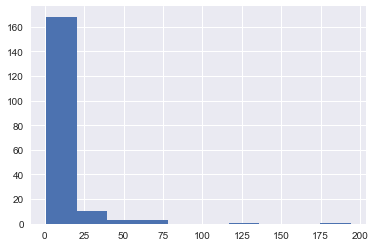

In [148]:
plt.hist(views)

(array([  1.74600000e+03,   1.79000000e+02,   7.10000000e+01,
          3.90000000e+01,   2.60000000e+01,   1.80000000e+01,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          5.00000000e+00]),
 array([   0.,   12.,   24.,   36.,   48.,   60.,   72.,   84.,   96.,
         108.,  120.]),
 <a list of 10 Patch objects>)

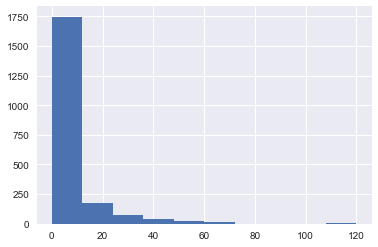

In [147]:
plt.hist(view_df["time_spent_mins"])

1445

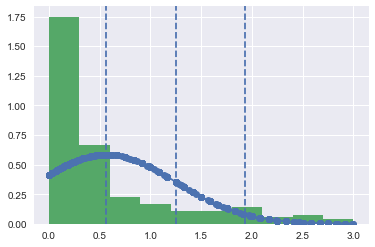

In [154]:
#### import pylab as pl
new_view = view_df[view_df["time_spent_mins"]<=3]
len(new_view) #(20 mins, 1874/2085, 10% reduced) (12 mins, 1746/2085, 16% reduced)(6 mins, 1607/2085, 23% reduced)
# (4 mins, 1513/2085, 28% reduced)

h = sorted(new_view["time_spent_mins"])  #sorted

fit = norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed

pl.plot(h,fit,'-o')

pl.hist(h,normed=True)

pl.axvline(x = np.mean(h), linestyle='--')
pl.axvline(x = np.mean(h) + np.std(h), linestyle='--')
pl.axvline(x = np.mean(h) + 2*np.std(h), linestyle='--')
len(new_view)

In [156]:
#(view_df.groupby("view_app_group")["time_spent_mins"].sum()).plot.kde()
len(view_df.user_id.unique())

213

In [76]:
#view_df["weekday"].plot.kde()

In [77]:
view_df.view_app_group.unique()

array(['CHROME', 'IE11', 'SAFARI', 'EDGE', 'FIREFOX', 'MOBILE_SAFARI', nan,
       'CHROME_MOBILE'], dtype=object)

([<matplotlib.axis.XTick at 0x123366610>,
 <a list of 7 Text xticklabel objects>)

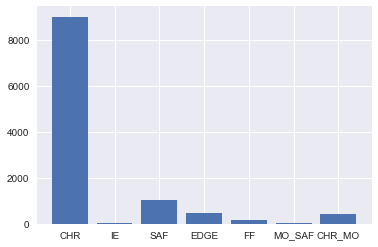

In [157]:
plt.bar(xrange(0,7), view_df.groupby("view_app_group")["time_spent_mins"].sum())
plt.xticks(xrange(0,7),['CHR', 'IE', 'SAF', 'EDGE', 'FF', 'MO_SAF',
       'CHR_MO'])
# plt.xlabel("Viewing Application")
# plt.ylabel("Total View Time in Minutes")
# plt.title("Time Spent Vs View App")

([<matplotlib.axis.XTick at 0x12346d550>,
 <a list of 7 Text xticklabel objects>)

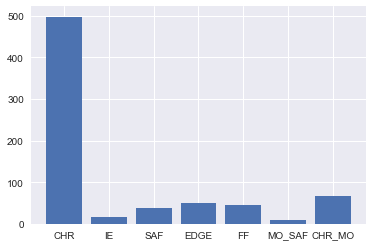

In [158]:
plt.bar(xrange(0,7), new_view.groupby("view_app_group")["time_spent_mins"].sum())
plt.xticks(xrange(0,7),['CHR', 'IE', 'SAF', 'EDGE', 'FF', 'MO_SAF',
       'CHR_MO'])

([<matplotlib.axis.XTick at 0x12384fd90>,
 <a list of 4 Text xticklabel objects>)

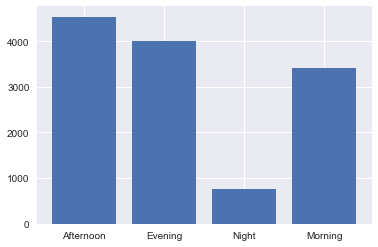

In [161]:
plt.bar(xrange(0,4), view_df.groupby("time_of_day")["time_spent_mins"].sum())
plt.xticks(xrange(0,4),["Afternoon", "Evening", "Night", "Morning"])
# plt.xlabel("Time of Day")
# plt.ylabel("Total View Time in Minutes")
# plt.title("TW - Time Spent Vs Time of Day")

([<matplotlib.axis.XTick at 0x121b6fdd0>,
 <a list of 4 Text xticklabel objects>)

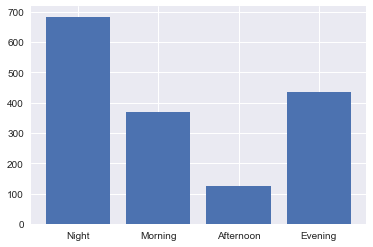

In [81]:
plt.bar(xrange(0,4), new_view.groupby("time_of_day")["time_spent_mins"].count())
plt.xticks(xrange(0,4),["Afternoon", "Evening", "Night", "Morning"])


In [82]:
def get_view_time_per_user(unique_users, view_df):
    for user in unique_users:
        temp_time = view_df["user_id"]

([<matplotlib.axis.XTick at 0x12364ce50>,
 <a list of 7 Text xticklabel objects>)

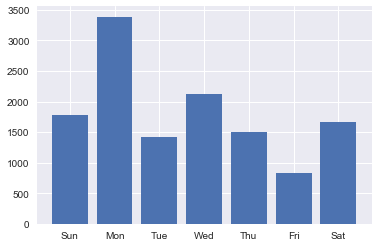

In [162]:
plt.bar(xrange(0,7), view_df.groupby("weekday")["time_spent_mins"].sum())
plt.xticks(xrange(0,7),["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])
#plt.xlabel("Day of Week")
#plt.ylabel("Total View Time in Minutes")
#plt.title("TW - Time Spent Vs Day of Week")

In [84]:
# Get the time spent on different apps
# def get_time_spent(view_df):
#     time_spent_secs = view_df["time_spent_in_seconds"].sum()
#     view_apps = view_df["view_app_group"].unique()

#     time_spent_dict = {}
#     for v in view_apps:
#         temp_time = view_df[view_df.view_app_group == v]["time_spent_in_seconds"].sum()
#         time_spent_dict[v] = [temp_time, float(temp_time)*100/time_spent_secs]
#     return time_spent_dict

# get_time_spent(view_df)

([<matplotlib.axis.XTick at 0x123ba5410>,
 <a list of 3 Text xticklabel objects>)

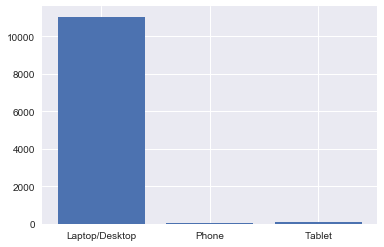

In [163]:
plt.bar(xrange(0,3), view_df.groupby("viewing_device")["time_spent_mins"].sum())
plt.xticks(xrange(0,3),["Laptop/Desktop", "Phone", "Tablet"])

In [164]:
#sns.stripplot(x="view_app_group", y="time_spent_mins", data=view_df)
#plt.bar(xrange(0,8), view_df.groupby("view_app_group")["time_spent_mins"].sum())

In [165]:
#sns.boxplot(x="view_app_group", y="time_spent_mins", data=view_df, hue = "view_app_group")


In [166]:
#sns.barplot(x="view_app_group", y="time_spent_mins", data=view_df, hue = "view_app_group")


In [167]:
#sns.countplot(x="view_app_group", data=view_df, hue = "view_app_group")


In [168]:
unique_view_app = view_df["view_app_group"].unique()
len(unique_view_app)

8

([<matplotlib.axis.XTick at 0x123d10110>,
 <a list of 7 Text xticklabel objects>)

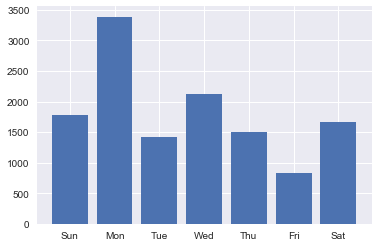

In [169]:
plt.bar(xrange(0,7), view_df.groupby("weekday")["time_spent_mins"].sum())
plt.xticks(xrange(0,7),["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])

([<matplotlib.axis.XTick at 0x123ba5590>,
 <a list of 7 Text xticklabel objects>)

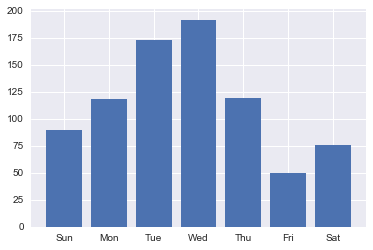

In [170]:
plt.bar(xrange(0,7), new_view.groupby("weekday")["time_spent_mins"].sum())
plt.xticks(xrange(0,7),["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])

In [93]:
#plt.bar(xrange(0,9),view_df.groupby("view_app_group")["time_spent_mins"].sum())

In [94]:
#sns.stripplot(x=view_df["view_app_group"], y=view_df["time_spent_mins"], data=view_df, jitter=True)


In [95]:
#sns.stripplot(x=view_df["weekday"], y=view_df["time_spent_mins"], data=view_df, jitter=True)



([<matplotlib.axis.XTick at 0x12217bfd0>,
 <a list of 7 Text xticklabel objects>)

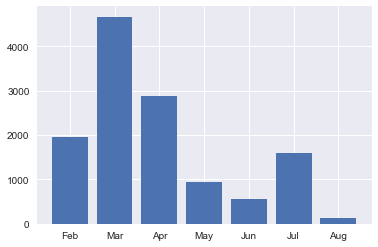

In [96]:
plt.bar(xrange(0,7), view_df.groupby("month")["time_spent_mins"].sum())
plt.xticks(xrange(0,7),["Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug"])

([<matplotlib.axis.XTick at 0x1222e96d0>,
 <a list of 7 Text xticklabel objects>)

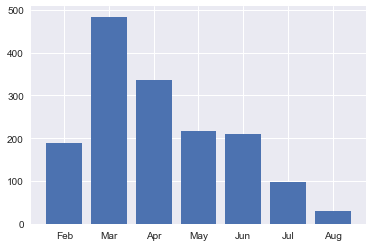

In [97]:
plt.bar(xrange(0,7), new_view.groupby("month")["time_spent_mins"].sum())
plt.xticks(xrange(0,7),["Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug"])

([<matplotlib.axis.XTick at 0x122401f10>,
 <a list of 7 Text xticklabel objects>)

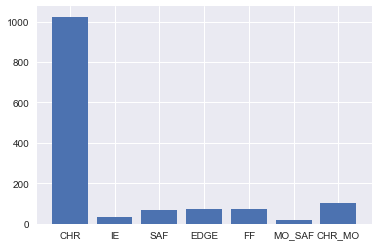

In [98]:
plt.bar(xrange(0,7), new_view.groupby("view_app_group")["time_spent_mins"].sum())
plt.xticks(xrange(0,7),['CHR', 'IE', 'SAF', 'EDGE', 'FF', 'MO_SAF',
       'CHR_MO'])

([<matplotlib.axis.XTick at 0x123f3d9d0>,
 <a list of 4 Text xticklabel objects>)

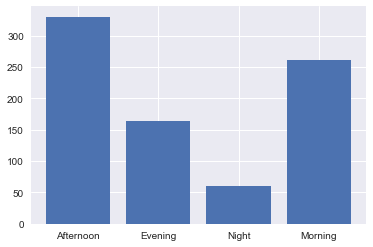

In [171]:
plt.bar(xrange(0,4), new_view.groupby("time_of_day")["time_spent_mins"].sum())
plt.xticks(xrange(0,4),["Afternoon", "Evening", "Night", "Morning"])


([<matplotlib.axis.XTick at 0x123f3d910>,
 <a list of 7 Text xticklabel objects>)

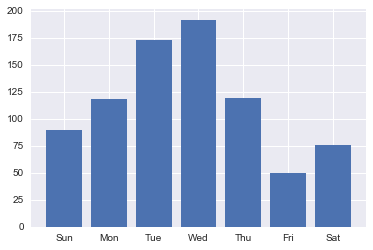

In [172]:
plt.bar(xrange(0,7), new_view.groupby("weekday")["time_spent_mins"].sum())
plt.xticks(xrange(0,7),["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])

([<matplotlib.axis.XTick at 0x12321e890>,
 <a list of 7 Text xticklabel objects>)

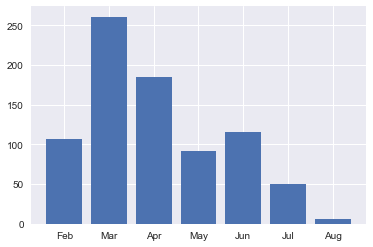

In [173]:
plt.bar(xrange(0,7), new_view.groupby("month")["time_spent_mins"].sum())
plt.xticks(xrange(0,7),["Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug"])

In [102]:
# clusterer = KMeans(n_clusters=7, random_state=10)
# clusterer.fit(X)

